In [383]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
win_pity_counts = cleaned_df[cleaned_df.is_win == 1].pity_counter.values
win_pity_counts = np.sort(win_pity_counts)
p10_index = len(win_pity_counts) * 0.1
p50_index = len(win_pity_counts) * 0.5
p90_index = len(win_pity_counts) * 0.9
print("p10, p50, p90: ", win_pity_counts[int(p10_index)], win_pity_counts[int(p50_index)], win_pity_counts[int(p90_index)])

p10, p50, p90:  13 75 79


Based on this: http://www.metalogdistributions.com/equations/sptboundedmetalog.html
* Original paper introduces as "SPT Log Metalog" used for bounded distribution (since our data can only range between 0 to 90)

In [ ]:
def metalog_qdf(y, a: np.ndarray, bl: float = 0.0, bu: float = 90.0):
    """
    Calculate the quantile function for SPT parameterization of the metalog distribution.
    """
    if y == 0:
        return bl
    if y == 1:
        return bu

    a1, a2, a3 = a
    y_log_term = np.log(y / (1 - y))
    y_term = y - 0.5
    M_y = a1 + a2 * y_log_term + a3 * y_term * y_log_term

    return (bl + bu * np.exp(M_y)) / (1 + np.exp(M_y))

In [ ]:
def metalog_pdf(y, a: np.ndarray, bl: float = 0.0, bu: float = 90.0):
    """
    Calculate the quantile function for SPT parameterization of the metalog distribution.
    """
    if y == 0 or y == 1:
        return 0

    _, a2, a3 = a

    y_term = y * (1 - y)
    y_log_term = np.log(y / (1 - y))

    m_y = 1 / (a2 / y_term + a3 * (((y - 0.5) / y_term)) + y_log_term)
    M_y = metalog_qdf(y, a, bl, bu)

    return m_y * ((1 + np.exp(M_y)) ** 2 / ((bu - bl) * np.exp(M_y)))

In [ ]:
def check_feasibility(alpha, gamma_10, gamma_50, gamma_90, bl: float = 0.0, bu: float = 90.0):
    k_a = 0.5 * (1 - 1.66711 * (0.5 - alpha))

    lower_bound = (bl + bu * (gamma_10 ** (1 - k_a)) * gamma_90 ** (k_a)) * np.reciprocal(1 + (gamma_10 ** (1 - k_a)) * (gamma_90 ** k_a))
    upper_bound = (bl + bu * (gamma_10 ** k_a) * gamma_90 ** (1 - k_a)) * np.reciprocal(1 + (gamma_10 ** k_a) * (gamma_90 ** (1 - k_a)))

    print("lower bound: ", lower_bound)
    print("upper bound: ", upper_bound)
    print("gamma_50: ", gamma_50)

    return lower_bound <= gamma_50 <= upper_bound, lower_bound, upper_bound

In [ ]:
def calculate_constants(q10, q50, q90, bl: float = 0.0, bu: float = 90.0):
    """
    Calculate the constants for the metalog distribution.
    """
    a = np.zeros(3)
    alpha = 0.1
    
    gamma_10 = (q10 - bl) / (bu - q10)
    gamma_50 = (q50 - bl) / (bu - q50)
    gamma_90 = (q90 - bl) / (bu - q90)

    # Check feasibility
    is_feasible, lwr, upr = check_feasibility(alpha, gamma_10, gamma_50, gamma_90, bl, bu)

    if not is_feasible:
        raise ValueError(f"The parameters are not feasible for the metalog distribution: {lwr} <= {gamma_50} <= {upr}")

    a[0] = np.log(gamma_50)
    a[1] = 0.5 * np.reciprocal(np.log ((1 - alpha) / alpha)) * np.log(gamma_90 / gamma_10)
    a[2] = np.reciprocal((1 - 2*alpha) * np.log((1 - alpha) / alpha)) * np.log((gamma_90*gamma_10) / gamma_50 ** 2)

    return a

In [ ]:
a = calculate_constants(1, 71, 80, bl=0, bu=90)
a

lower bound:  2.9219911453857095
upper bound:  65.53506115786132
gamma_50:  3.736842105263158


array([ 1.3182409 ,  1.49463054, -2.87048299])

lower bound:  2.9219911453857095
upper bound:  65.53506115786132
gamma_50:  3.736842105263158


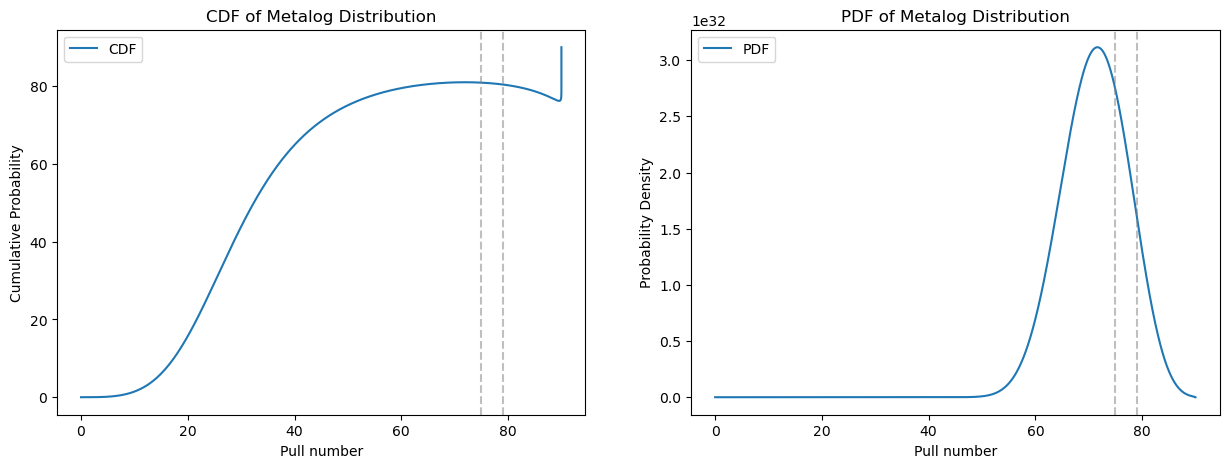

In [ ]:
# convert y to pity counter
x = np.linspace(0, 90, 100000)
y = np.linspace(0, 1, 100000)
a = calculate_constants(1, 71, 80, bl=0, bu=90)

xfunc = lambda y : metalog_qdf(y, a)
yfunc = lambda y : metalog_pdf(y, a)

xs = np.array(list(map(xfunc, y)))
ys = np.array(list(map(yfunc, y)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(x, xs, label="CDF")
ax1.set_xlabel("Pull number")
ax1.set_ylabel("Cumulative Probability")
ax1.set_title("CDF of Metalog Distribution")
ax1.axvline(75, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(79, color='gray', linestyle='--', alpha=0.5)
ax1.legend()

ax2.plot(x, ys, label="PDF")
ax2.set_xlabel("Pull number")
ax2.set_ylabel("Probability Density")
ax2.set_title("PDF of Metalog Distribution")
ax2.axvline(75, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(79, color='gray', linestyle='--', alpha=0.5)
ax2.legend()

#### Metalog implementation tried

In [17]:
# this is based on the bounded metalog equations

In [19]:
def z_transform(x, lower, upper):
    """Transform x to the logit scale."""
    return np.log((x - lower) / (upper - x))

In [74]:
def metalog_ppf(y, a, k):
    """
    Compute the percent point function (inverse CDF) of the metalog distribution.

    Args:
        y: The cumulative probability, 0 < y < 1.
        a: The array of the parameters of the metalog distribution.
        k: The number of parameters.
    """
    y_term = np.log(y / (1 - y))
    y_05 = y - 0.5

    M_y = a[0] + a[1] * y_term

    if k == 3:
       M_y = M_y + a[2] * y_05 * y_term
    
    if k == 4:
        M_y = M_y + a[2] * y_05 * y_term + a[3] * y_05

    if k >= 5:
        M_y = M_y + a[2] * y_05 * y_term + a[3] * y_05

        for i in range(5, k+1):
            if i % 2 == 1:
                M_y = M_y + a[i-1] * y_05 ** ((i-1)/2)

            else:
                M_y = M_y + a[i-1] *  y_05 ** (i/2-1) * y_term
    return M_y

In [75]:
def metalog_pdf(y, a, k):
    """
    Compute the probability density function (PDF) of the metalog distribution.

    Args:
        y: The cumulative probability, 0 < y < 1.
        a: The array of the parameters of the metalog distribution.
        k: The number of parameters.
    """
    y_ln_term = np.log(y / (1 - y))
    y_term = y * (1 - y)
    y_05 = y - 0.5

    m_y = a[1] / y_term
    
    if k == 3:
        m_y = a[1] / y_term + a[2] * (y_05 / y_term + y_ln_term)
    
    if k == 4:
        m_y = a[1] / y_term + a[2] * (y_05 / y_term + y_ln_term) + a[3]
    
    if k >= 5:
        m_y = a[1] / y_term + a[2] * (y_05 / y_term + y_ln_term) + a[3]

        for i in range(5, k+1):
            if i % 2 == 1:
                m_y = m_y + a[i-1] * ((i-1) / 2) * y_05 ** ((i-3)/2)
            else:
                m_y = m_y + a[i-1] * ((y_05 ** (i/2-1) / y_term) + (i/2-1)) * (y_05 ** (i/2-2) * y_ln_term)

    return np.reciprocal(m_y)

In [76]:
def calculate_constants(x, y, k):
    """
    Calculate the constants for the metalog distribution.
    
    Args:
        x: The array of the quantiles.
        y: The array of the probabilities.
        k: The number of parameters.
    """
    m = len(x)
    Y = np.zeros(shape=(m, k))
    print("Y.shape", Y.shape)
    Y[:, 0] = 1
    Y[:, 1] = np.log(y / (1 - y))
    
    if k == 3:
        Y[:, 2] = (y - 0.5) * np.log(y / (1 - y))

    if k == 4:
        Y[:, 2] = (y - 0.5) * np.log(y / (1 - y))
        Y[:, 3] = y - 0.5

    if k >= 5:
        Y[:, 2] = (y - 0.5) * np.log(y / (1 - y))
        Y[:, 3] = y - 0.5
        
        for i in range(5, k+1):
            if i % 2 == 1:
                Y[:, i-1] = (y - 0.5) ** ((i-1)/2)
            else:
                Y[:, i-1] = (y - 0.5) ** ((i/2)-1) * np.log(y / (1 - y))

    # calculate the constants
    YT = Y.T
    a = np.linalg.inv(YT @ Y) @ YT @ x
    return a


In [87]:
# calculate the constants
x = np.array([13, 76, 78, 80])
y = np.array([0.1, 0.5, 0.8, 0.9])
k = 4
a = calculate_constants(x, y, k)
print("a", a)

# calculate the percent point function
metalog_pdf(y, a, k)

Y.shape (4, 4)
a [  76.           35.03377627  -33.56507148 -108.69268567]


array([0.0019861 , 0.03180417, 1.24558178, 0.01734804])

Y.shape (4, 4)


/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_6649/3138272314.py:10: RuntimeWarning: divide by zero encountered in log
  y_ln_term = np.log(y / (1 - y))
/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_6649/3138272314.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  m_y = a[1] / y_term
/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_6649/3138272314.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  m_y = a[1] / y_term + a[2] * (y_05 / y_term + y_ln_term) + a[3]
/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_6649/3138272314.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  y_ln_term = np.log(y / (1 - y))
/var/folders/qf/j7wht0hj5z199zk3gbhnlfj00000gn/T/ipykernel_6649/3138272314.py:20: RuntimeWarning: invalid value encountered in scalar add
  m_y = a[1] / y_term + a[2] * (y_05 / y_term + y_ln_term) + a[3]


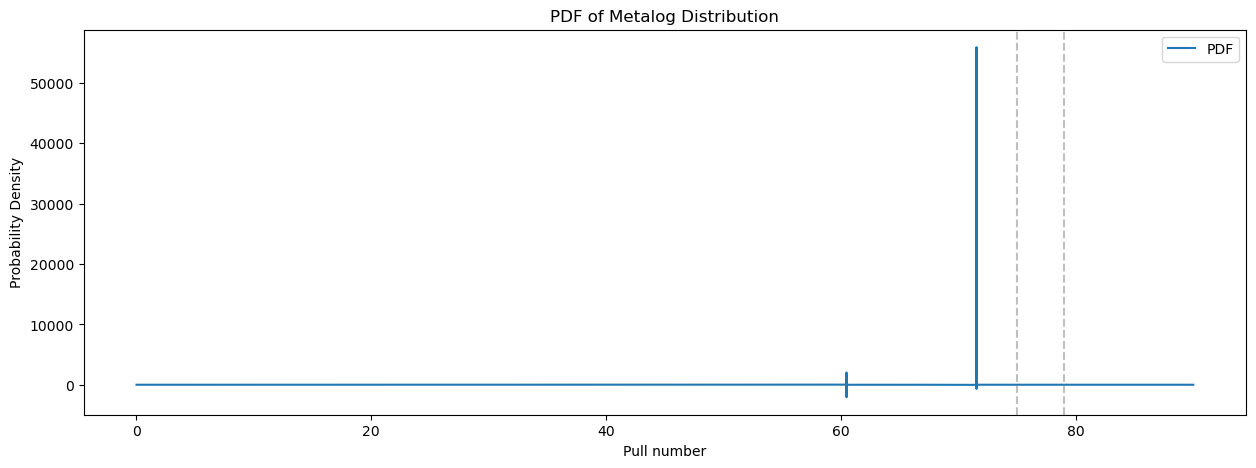

In [ ]:
# convert y to pity counter
x = np.linspace(0, 90, 100000)
y = np.linspace(0, 1, 100000)

k = 4
observed_x = np.array([13, 76, 78, 80])
observed_y = np.array([0.1, 0.5, 0.8, 0.9])
a = calculate_constants(observed_x, observed_y, k=k)

yfunc = lambda y : metalog_pdf(y, a, k)

ys = np.array(list(map(yfunc, y)))

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

axes.plot(x, ys, label="PDF")
axes.set_xlabel("Pull number")
axes.set_ylabel("Probability Density")
axes.set_title("PDF of Metalog Distribution")
axes.axvline(75, color='gray', linestyle='--', alpha=0.5)
axes.axvline(79, color='gray', linestyle='--', alpha=0.5)
axes.legend()

### Metalog implementation from pymetalog

In [384]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'pymetalog'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [385]:
import pymetalog as mt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

#### Metalog fitting with scraped data

In [386]:
# x = np.array([13, 76, 78, 80])
# y = np.array([0.1, 0.5, 0.8, 0.9])
pull_data = np.sort(np.array([13, 40, 75,  6, 76, 78, 61, 74, 75, 79]))
print("pull_data: ", pull_data)
dist = mt.metalog(x = pull_data, term_limit=3, bounds=[0, 90], boundedness="b")

pull_data:  [ 6 13 40 61 74 75 75 76 78 79]


/Users/haejin.cho/Documents/OMSCS/ISYE6420/pymetalog/pymetalog/support.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x.loc[i, "probs"] = 0.5 / l


In [387]:
dist.output_dict['dataValues']

,x,probs,z
0,6,0.05,-2.639057
1,13,0.15,-1.778856
2,40,0.25,-0.223144
3,61,0.35,0.743578
4,74,0.45,1.531476
5,75,0.55,1.609438
6,75,0.65,1.609438
7,76,0.75,1.691676
8,78,0.85,1.871802
9,79,0.95,1.971553


In [388]:
dist.output_dict['A']

,a2,a3
0,0.638790,1.271196
1,0.847675,0.847675
2,0.000000,-1.369050


In [389]:
mt.summary(dist)

 -----------------------------------------------
 Summary of Metalog Distribution Object
 -----------------------------------------------
 
Parameters
 Term Limit:  3 
 Term Lower Bound:  2 
 Boundedness:  b 
 Bounds (only used based on boundedness):  [0, 90] 
 Step Length for Distribution Summary:  0.01 
 Method Use for Fitting:  any 
 

 Validation and Fit Method Number of Data Points Used:  10 

 term valid method
    2   yes    OLS
    3   yes    OLS


{'pdf': <Figure size 1300x400 with 2 Axes>,
 'cdf': <Figure size 1300x400 with 2 Axes>}

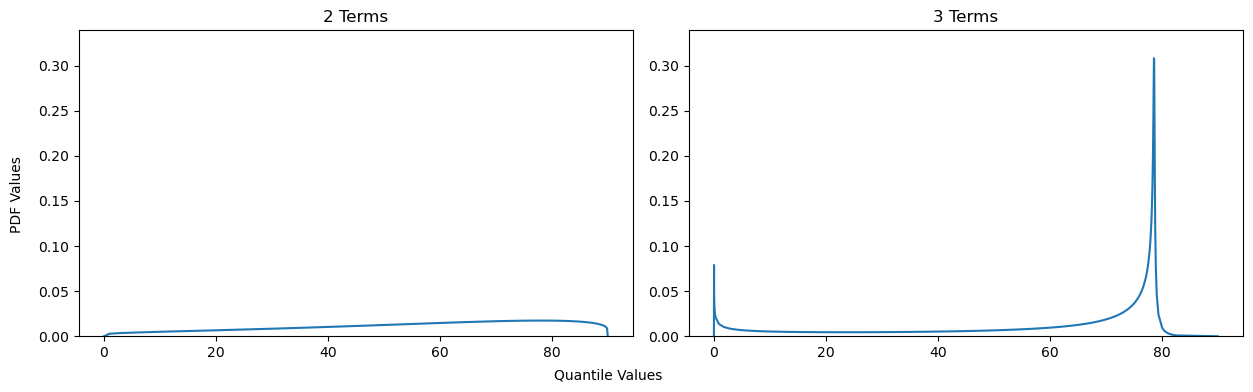

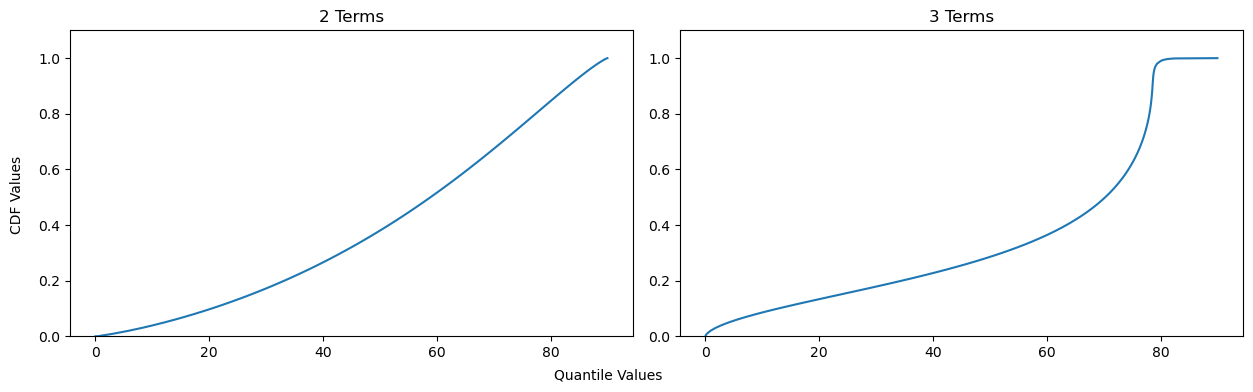

In [390]:
mt.plot(dist, figsize=(13,4))

In [95]:
dist.output_dict["A"]

,a2,a3
0,0.638790,1.271196
1,0.847675,0.847675
2,0.000000,-1.369050


In [96]:
dist.output_dict["M"][["m3","M3",'y']][:10]

,m3,M3,y
0,0.000000,0.000000,0.000
1,0.078987,0.023964,0.001
2,0.053875,0.023964,0.002
3,0.042882,0.044968,0.003
4,0.036373,0.070411,0.004
5,0.031951,0.099832,0.005
6,0.028700,0.132921,0.006
7,0.026180,0.169455,0.007
8,0.024156,0.209263,0.008
9,0.022483,0.252210,0.009


In [97]:
mt.support.pdfMetalog(
    a=dist.output_dict["A"]["a3"].values,
    y=0.009,
    t=3,
    bounds=[0,90],
    boundedness="b"
)

0.02248339673580346

In [98]:
mt.support.quantileMetalog(
    a=dist.output_dict["A"]["a3"].values,
    y=0.009,
    t=3,
    bounds=[0,90],
    boundedness="b"
)

0.25221014972676686

### PyMC Sampling

In [99]:
from scipy.optimize import root_scalar

In [100]:
def logpMetalog_pt(y, a, t, bounds, boundedness="b"):
    pdf_val = mt.support.pdfMetalog_pt(a, y, t, bounds, boundedness)
    return pt.log(pdf_val)

In [101]:
def inverse_quantile_metalog(x, a, t, bounds, boundedness="b"):
    def objective(y):
        return mt.support.quantileMetalog(a, y, t, bounds, boundedness) - x
    result = root_scalar(objective, bracket=[1e-6, 1 - 1e-6], method="brentq")
    return result.root if result.converged else None

In [102]:
user3_df = pd.read_csv("./data/warp_data_user3_whale.csv", skiprows=1)
pull_data = user3_df[user3_df.rarity == 5][["pity_counter"]]

In [43]:
dist.output_dict["A"]

,a2,a3
0,0.638790,1.271196
1,0.847675,0.847675
2,0.000000,-1.369050


In [114]:
pull_data.pity_counter.values

array([13, 40, 75,  6, 76, 78, 61, 74, 75, 79])

In [106]:
user3_df["is_win"] = user3_df["rarity"] == 5

In [107]:
user3_df["is_win"] = user3_df["is_win"].astype(int)

In [170]:
with pm.Model() as model:
    lower_bound = 0
    upper_bound = 90
    
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]
    
    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    θ = pm.DensityDist("theta", logp=metalog_logp)
    p = pm.Deterministic("p", pm.math.exp(θ))

    # Likelihood: Bernoulli per-pull
    y = pm.Bernoulli("y", p=p, observed=user3_df["is_win"].values)

    # Posterior sampling
    trace = pm.sample(10000, tune=1000, return_inferencedata=True,)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2 seconds.


In [171]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-4.112,0.321,-4.723,-3.522,0.003,0.002,16338.0,23061.0,1.0
p,0.017,0.005,0.008,0.027,0.000,0.000,16338.0,23061.0,1.0


<Axes: title={'center': 'p'}>

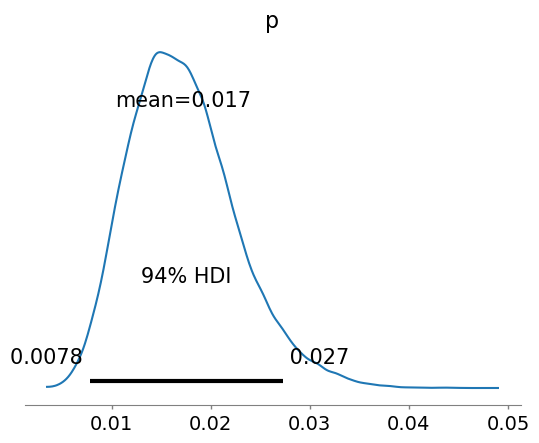

In [172]:
az.plot_posterior(trace, var_names=["p"])

In [ ]:
user3_df = pd.read_csv("./data/warp_data_user3_whale.csv", skiprows=1)
pull_data = user3_df[user3_df.rarity == 5][["pity_counter"]]

with pm.Model() as model:
    lower_bound = 0
    upper_bound = 90
    
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]
    
    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    θ = pm.DensityDist("theta", logp=metalog_logp)
    p = pm.Deterministic("p", pm.math.sigmoid(θ))
    mu = pm.Deterministic("mu", 1 / p)

    y_base = pm.Geometric.dist(p=p)
    y = pm.Truncated("y", y_base, lower=1, upper=90, observed=user3_df["pity_counter"].values)

    # Posterior sampling
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [246]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-4.168,0.109,-4.369,-3.962,0.002,0.002,1962.0,2239.0,1.0
p,0.015,0.002,0.012,0.018,0.000,0.000,1962.0,2239.0,1.0
mu,65.991,7.262,53.578,79.980,0.168,0.120,1962.0,2239.0,1.0


In [251]:
# student-t

with pm.Model() as m_student:
    nu = 1
    lower_bound = 0
    upper_bound = 90
    
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]
    
    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    # sigma = pm.HalfNormal("sigma", sigma=20)
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    θ = pm.DensityDist("theta", logp=metalog_logp)
    p = pm.Deterministic("p", pm.math.sigmoid(θ))
    mu = pm.Deterministic("mu", 1 / -np.log(1 - p))

    # likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=pull_data)

    # sample
    trace_student = pm.sample(1000, tune=1000, cores=1, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, theta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [252]:
az.summary(trace_student)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-4.294,0.075,-4.388,-4.172,0.006,0.004,326.0,167.0,1.01
tau,0.083,0.132,0.001,0.302,0.007,0.005,286.0,349.0,1.01
sigma,6.976,5.690,1.183,17.488,0.359,0.254,286.0,349.0,1.01
p,0.014,0.001,0.012,0.015,0.000,0.000,326.0,167.0,1.01
mu,73.926,4.888,65.355,81.013,0.393,0.278,326.0,167.0,1.01


In [253]:
with m_student:
    ppc_student = pm.sample_posterior_predictive(trace_student, var_names=["y"])

Sampling: [y]


Output()

In [254]:
y_ppc = ppc_student.posterior_predictive["y"].values.flatten()
print("Posterior predictive mean (direct):", y_ppc.mean())

Posterior predictive mean (direct): 78.58291874915864


### Using user1 and user2 data to improve prediction

In [483]:
user1_df = pd.read_csv("./data/warp_data_user1.csv")
user2_df = pd.read_csv("./data/warp_data_user2.csv")
user3_df = pd.read_csv("./data/warp_data_user3_whale.csv", skiprows=1)

In [484]:
user1_df = user1_df[user1_df["type"] == 11]
user1_df = user1_df.reset_index().drop(columns=["index"])
user2_df = user2_df[user2_df["type"] == 11]
user2_df = user2_df.reset_index().drop(columns=["index"])

In [485]:
curr_pity = 0
for i in range(len(user1_df)):
    curr_pity += 1
    user1_df.loc[i, "pity_counter"] = curr_pity

    if user1_df.loc[i, "rarity"] == 5:
        curr_pity = 0

In [486]:
curr_pity = 0
for i in range(len(user2_df)):
    curr_pity += 1
    user2_df.loc[i, "pity_counter"] = curr_pity

    if user2_df.loc[i, "rarity"] == 5:
        curr_pity = 0

In [487]:
user1_df["user"] = "user1"
user2_df["user"] = "user2"
user3_df["user"] = "user3"

In [488]:
user1_df = user1_df[["pity_counter", "user", "rarity"]]
user1_df = user1_df[user1_df["rarity"] == 5]
user2_df = user2_df[["pity_counter", "user", "rarity"]]
user2_df = user2_df[user2_df["rarity"] == 5]
user3_df = user3_df[["pity_counter", "user", "rarity"]]
user3_df = user3_df[user3_df["rarity"] == 5]


In [489]:
all_data = pd.concat([user1_df, user2_df, user3_df], ignore_index=True)
user_idx, user_labels = pd.factorize(all_data["user"])
pull_data = all_data["pity_counter"].values

In [490]:
with pm.Model() as m_hier_student:
    nu = 1
    lower_bound = 0
    upper_bound = 90

    # Metalog prior
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]

    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    # Hyperpriors
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # User-specific θs from Metalog prior
    θ_user = pm.DensityDist("theta_user", logp=metalog_logp, shape=len(user_labels))

    # Map θ_user to each user's pull
    θ_obs = θ_user[user_idx]
    p = pm.Deterministic("p", pm.math.sigmoid(θ_obs))
    mu = pm.Deterministic("mu", 1 / -pm.math.log(1 - p))

    # Likelihood
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=pull_data)

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta_user]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [492]:
mu_samples = trace.posterior["mu"]
user1_mu = mu_samples[..., all_data["user"] == "user1"]
user2_mu = mu_samples[..., all_data["user"] == "user2"]
user3_mu = mu_samples[..., all_data["user"] == "user3"]

p_samples = trace.posterior["p"]
user1_p = p_samples[..., all_data["user"] == "user1"]
user2_p = p_samples[..., all_data["user"] == "user2"]
user3_p = p_samples[..., all_data["user"] == "user3"]

In [493]:
def calc_hdi(samples: np.ndarray, alpha: float = 0.05) -> tuple:
    """
    Calculate minimum-width credible interval (HPD credible set)

    samples: samples from posterior
    alpha: credibility of the interval == 1 - alpha

    returns tuple of the lower and upper bounds of the interval
    """
    n = len(samples)
    x = np.sort(samples)

    lower_idx = int(np.floor(alpha * n))
    x_left = x[:lower_idx]
    x_right = x[n - lower_idx :]

    idx = np.argmin(x_right - x_left)

    upper_bound = x_right[idx]
    lower_bound = x_left[idx]

    return lower_bound, upper_bound

In [494]:
print(f"Mean pull number of user1: {user1_mu.values.flatten().mean():.4}")
lwr1, upr1 = calc_hdi(user1_mu.values.flatten())
print(f"95% HDI credible interval of user1: ({lwr1:.4}, {upr1:.4})")

print(f"Mean pull number of user2: {user2_mu.values.flatten().mean():.4}")
lwr2, upr2 = calc_hdi(user2_mu.values.flatten())
print(f"95% HDI credible interval of user2: ({lwr2:.4}, {upr2:.4})")

print(f"Mean pull number of user3: {user3_mu.values.flatten().mean():.4}")
lwr3, upr3 = calc_hdi(user3_mu.values.flatten())
print(f"95% HDI credible interval of user3: ({lwr3:.4}, {upr3:.4})")

Mean pull number of user1: 70.07
95% HDI credible interval of user1: (25.88, 90.74)
Mean pull number of user2: 74.83
95% HDI credible interval of user2: (62.88, 86.99)
Mean pull number of user3: 73.84
95% HDI credible interval of user3: (65.0, 80.91)


In [495]:
print(f"Mean p of user1: {user1_p.values.flatten().mean():.4}")
lwr1, upr1 = calc_hdi(user1_p.values.flatten())
print(f"95% HDI credible interval of user1: ({lwr1:.4}, {upr1:.4})")

print(f"Mean p number of user2: {user2_p.values.flatten().mean():.4}")
lwr2, upr2 = calc_hdi(user2_p.values.flatten())
print(f"95% HDI credible interval of user2: ({lwr2:.4}, {upr2:.4})")

print(f"Mean p number of user3: {user3_p.values.flatten().mean():.4}")
lwr3, upr3 = calc_hdi(user3_p.values.flatten())
print(f"95% HDI credible interval of user3: ({lwr3:.4}, {upr3:.4})")

Mean p of user1: 0.01662
95% HDI credible interval of user1: (0.01035, 0.03373)
Mean p number of user2: 0.01342
95% HDI credible interval of user2: (0.01143, 0.01578)
Mean p number of user3: 0.0135
95% HDI credible interval of user3: (0.01223, 0.0152)


### Comparison: non-informative prior; normal likelihood

In [412]:
with pm.Model() as m_hier_student:
    # nu = 1
    lower_bound = 0
    upper_bound = 90

    # Metalog prior
    a_vals = dist.output_dict["A"]["a3"].values
    t = 3
    bounds = [lower_bound, upper_bound]

    def metalog_logp(theta):
        return logpMetalog_pt(theta, a_vals, t, bounds, boundedness="b")

    # Hyperpriors
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # User-specific θs from Metalog prior
    θ_user = pm.DensityDist("theta_user", logp=metalog_logp, shape=len(user_labels))

    # Map θ_user to each user's pull
    θ_obs = θ_user[user_idx]
    p = pm.Deterministic("p", pm.math.sigmoid(θ_obs))
    mu = pm.Deterministic("mu", 1 / -pm.math.log(1 - p))

    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=pull_data)

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta_user]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [413]:
mu_samples = trace.posterior["mu"]
user1_mu = mu_samples[..., all_data["user"] == "user1"]
user2_mu = mu_samples[..., all_data["user"] == "user2"]
user3_mu = mu_samples[..., all_data["user"] == "user3"]

print(f"Mean pull number of user1: {user1_mu.values.flatten().mean():.4}")
lwr1, upr1 = calc_hdi(user1_mu.values.flatten())
print(f"95% HDI credible interval of user1: ({lwr1:.4}, {upr1:.4})")

print(f"Mean pull number of user2: {user2_mu.values.flatten().mean():.4}")
lwr2, upr2 = calc_hdi(user2_mu.values.flatten())
print(f"95% HDI credible interval of user2: ({lwr2:.4}, {upr2:.4})")

print(f"Mean pull number of user3: {user3_mu.values.flatten().mean():.4}")
lwr3, upr3 = calc_hdi(user3_mu.values.flatten())
print(f"95% HDI credible interval of user3: ({lwr3:.4}, {upr3:.4})")

Mean pull number of user1: 55.29
95% HDI credible interval of user1: (0.7935, 87.05)
Mean pull number of user2: 57.16
95% HDI credible interval of user2: (31.23, 83.55)
Mean pull number of user3: 55.71
95% HDI credible interval of user3: (36.07, 74.77)


In [400]:
# non-informative prior

with pm.Model() as m_hier_student:
    nu = 1  # degrees of freedom for Student's T

    # Non-informative prior over user-specific success probabilities
    p = pm.Beta("p", alpha=1, beta=1, shape=len(user_labels))

    # Convert p to expected value of geometric distribution (mean pulls to 5-star)
    mu = pm.Deterministic("mu", 1 / -pm.math.log(1 - p))

    # Map mu to observed users
    mu_obs = mu[user_idx]

    # Hierarchical variance via Gamma hyperprior
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)
    sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(tau))

    # Student's T likelihood over observed pulls
    y = pm.StudentT("y", mu=mu_obs, sigma=sigma, nu=nu, observed=pull_data)

    trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, tau]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [411]:
az.summary(trace, var_names=["p", "mu"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.086,0.195,0.009,0.618,0.014,0.010,204.0,480.0,1.02
p[1],0.014,0.009,0.011,0.018,0.001,0.000,349.0,159.0,1.01
p[2],0.014,0.001,0.012,0.016,0.000,0.000,595.0,379.0,1.02
mu[0],56.006,28.934,0.257,85.203,2.322,1.645,204.0,480.0,1.02
mu[1],73.244,9.746,53.903,85.840,0.792,0.561,349.0,159.0,1.01
mu[2],72.947,5.252,62.395,81.439,0.267,0.189,595.0,379.0,1.02
